
### IMDB Dense in TF

The code follows the IMDB one-class classification presented by Chollet's tf/kr  2nd ed book
starting in pp. 97.

after 20 epochs the metrics are
            TEST                        VALIDATION
    loss: 0.0051 - acc: 0.9993 - val_loss: 0.7089 - val_acc: 0.8662

after 5 epochs the metrics are
            TEST                        VALIDATION
    loss: 0.1486 - acc: 0.9522 - val_loss: 0.2806 - val_acc: 0.8876

The most recent version (2025_0204) is being updated to do the foillowing:

1. Get IMDB data from keras's load_data(args)
2. Convert the IMDB review (training, testing) into ragged arrays
3. Write ragged arrays into files.
4. Read files back to arrays in memory.  
6. Use the data from the files to process the IMDB data, using the same TF models that were used with the original data
8. Compare results
9. If results are OK, use the ragged arrays from files with PyTorch dense models





### Debugging a cell multiple times in VSC


VSC doesn't have a direct "repeat debug cell" button, but there are ways to repeat debug a cell multiple times:   

1. Ensure Correct Setup:

+ Ensure that the rigth Jupyter extension(s) are installed.
+ Select the right Python Kernel (tf, torch, etc)

2. Debugging the Cell:

+ Start Debugging: Right-click within the cell to debug and select "Debug Cell". 

+ Alternatively, use the debug controls at the top of the notebook editor (the play/pause buttons) after selecting the cell.

3. Repeating the Debugging Process:

+ There are two options to debug a cell multiple times : 

    + Option A (Easiest): Re-run the Cell via Shift+Enter or click the "Run Cell" button.  VSC will remember the breakpoints. 

    + Then, start debugging again (right-click -> "Debug Cell"). This will effectively
    start a new debugging session for the same cell.

    + Option B : Restart the Kernel: If a completely fresh start is needed, restart the kernel.

    + Then, re-run the cell and start the debugger.

4. NOTE:  The cell must contain all the code to be debugged. As far as I know, VSC will not go to a different cell during a devug session


In [1]:

from logging import logProcesses
import os, shutil
from platform import python_branch
from syslog import LOG_SYSLOG

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import optimizers
# from keras.layers import Dropout
# from keras.datasets import mnist

print ("TF Version   ", tf.__version__)
print ("TF Path      ", tf.__path__[0])
print("Keras version ", keras.__version__)
print("numpy version ", np.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-16 03:08:43.105827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739675323.120240    8215 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739675323.124219    8215 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 03:08:43.138419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version    2.18.0
TF Path       /usr/local/lib/python3.11/site-packages/keras/api/_v2
Keras version  3.8.0
numpy version  2.0.2
Num GPUs Available:  1


In [2]:

"""

This cell uses the imdb.load_data(args) from tf/keras to get the IMDB data. 
The code  is located at  

https://github.com/keras-team/keras/blob/master/keras/src/datasets/imdb.py

Most of the code is simple python. It uses two functions 

    from keras.src.utils.file_utils import get_file

get_file is long. Its purpose is only to get the file and its content. 
Most of the code goes through security loops to open the file, read the
data etc. Therefore I don't think I need to use the function or look at it.

    from keras.src.utils.python_utils import remove_long_seq

remove_long_seq is simpler, I got it and put it in a cell below.  

According to the docs in .../exerciseIMDB/data/src/datasets/imdb.py the function returns a tuple of 
NUMPY arrays as

   (train_data, train_labels), (test_data, test_labels)

The items in train_data are 

array([list([1, 14, 22, 16, 43, 530,  32]),
   list([1, 194, 1153, 194, 8255, 78, 95]),
   list([1, 14, 47, 8, 30, 31, 7, 4, 249, 7, 129,13]),
   list([1, 11, 6, 230, 245, 6401, 9, 6, 2]),
   list([1, 1446, 7079, 69, 72, 3305, 13, 84, 80, 124, 12, 9, 23]),
   list([1, 17, 6, 194, 337, 7, 4, 204, 131, 9])
  ], dtype=object)
 
 
array(...): object is np array.

[...]: The brackets enclose the contents of the array. The array is one-dimensional vector, 
  with elements of other Python objects.

list(...): Each element is a Python list. Each element in the array is a list of integers, 
  or "array of lists" or "ragged array", because the lists might have different lengths.

dtype=object:  The data type of each element in the array.  The array is holding pointers
  to arbitrary Python objects (in this case, the lists).  This is important because it means the NumPy array isn't storing the numerical data directly; it's holding references to the lists that store the data.  This can have performance implications.

ADVANTAGES

Varying Lengths: The lists inside the array have different lengths. Since the lists have
 different lengths, the object dtype is necessary.

Flexibility: Storing lists within the array combines the benefits of NumPy (like vectorized 
  operations, though they might not be as efficient with dtype=object) with the flexibility
  of lists (like different lengths and storing different data types within each list if needed).

DISADVANTAGES

Performance: NumPy's strength comes from its ability to perform fast numerical operations on
 homogeneous data. When dtype=object is used to store lists, we lose the performance benefit, because NumPy would have to work with standard, slower Python objects. 

Memory Overhead: This structure used more memory overhead than a standard NumPy array.

so when I see train_data[0:2500] = [[1,2,22,...], [1,194,1153], ... ]     


One way to save to disk ragged np arrays is using pickle. See Cell somewhere below


"""

# Get the data from tf/keras. Maybe I need to test the local data to ensure it is a bona fide version 

imdb = tf.keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data( num_words=10000)

print (train_data[0] )
print (test_data[0] )

print (train_labels[0] )
print (test_labels[0] )


print("train_data.dtype",  train_data.dtype )



[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4,

In [4]:
# transform train_data and test_data into ragged array and 
# save the ragged arrays to files via Pickle

import pickle

ragged_array = np.array([
    [1, 14, 22, 16, 43, 530, 32],
    [1, 194, 1153, 194, 8255, 78, 95],
    [1, 14, 47, 8, 30, 31, 7, 4, 249, 7, 129, 13], # Different length
    # ... other lists
], dtype=object)  # Important: dtype=object

# Save to disk
with open("./exerciseIMDB/data/ragged_array.pkl", "wb") as f:
    pickle.dump(ragged_array, f)

# Load from disk
with open("./exerciseIMDB/data/ragged_array.pkl", "rb") as f:
    loaded_ragged_array = pickle.load(f)

print(loaded_ragged_array)
print(loaded_ragged_array.dtype) # Will be object

# Save train_data to disk as ragged array
with open("./exerciseIMDB/data/train_data_as_ragged_array.pkl", "wb") as f:
    pickle.dump(train_data, f)

# Load from disk
with open("./exerciseIMDB/data/train_data_as_ragged_array.pkl", "rb") as f:
    train_data_ragged = pickle.load(f)

print("train_data_ragged[0]")
print(train_data_ragged[0])    

print("train_data_[20000]")
print(train_data[20000])    

#print("train_data_ragged[20000]")
#print(train_data_ragged[20000])    

# Save test_data to disk as ragged array
with open("./exerciseIMDB/data/test_data_as_ragged_array.pkl", "wb") as f:
    pickle.dump(test_data, f)

# Load from disk
with open("./exerciseIMDB/data/test_data_as_ragged_array.pkl", "rb") as f:
    test_data_ragged = pickle.load(f)

print("test_data_[0]")
print(test_data[0])    

print("test_data_ragged[0]")
print(test_data_ragged[0])    




[list([1, 14, 22, 16, 43, 530, 32])
 list([1, 194, 1153, 194, 8255, 78, 95])
 list([1, 14, 47, 8, 30, 31, 7, 4, 249, 7, 129, 13])]
object
train_data_ragged[0]
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104

In [5]:

import pickle

## Now save the labels

# Save train_labels to disk as ragged array
with open("./exerciseIMDB/data/train_labels_as_ragged_array.pkl", "wb") as f:
    pickle.dump(train_labels, f)

    # Save test_labels to disk as ragged array
with open("./exerciseIMDB/data/test_labels_as_ragged_array.pkl", "wb") as f:
    pickle.dump(test_labels, f)

# Load from disk
with open("./exerciseIMDB/data/train_labels_as_ragged_array.pkl", "rb") as f:
    train_labels_ragged = pickle.load(f)

# Load from disk
with open("./exerciseIMDB/data/train_labels_as_ragged_array.pkl", "rb") as f:
    test_labels_ragged = pickle.load(f)

# compare

print("train_labels[0]")
print(train_labels[0])    

print("train_labels_ragged[0]")
print(train_labels_ragged[0])    

print("train_labels[20000]")
print(train_labels[20000])    

print("train_labels_ragged[0]")
print(train_labels_ragged[0])    

print("test_labels[0]")
print(test_labels[0])  

print("test_labels_ragged[0]")
print(test_labels_ragged[0])    

print("test_labels[20000]")
print(test_labels[20000])  

print("test_labels_ragged[20000]")
print(test_labels_ragged[20000])    



train_labels[0]
1
train_labels_ragged[0]
1
train_labels[20000]
0
train_labels_ragged[0]
1
test_labels[0]
0
test_labels_ragged[0]
1
test_labels[20000]
0
test_labels_ragged[20000]
0


In [6]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate (sequences):
        results[i, sequence] = 1.
    return results

def print_review( item ) :
  for i in item :
    print (i)


In [6]:
# Now that train and test data in are text files, do the following
# 1. write code to get the data from those files,
# 2. convert to tensors, 
# 3. Do the processing as it was done with the original tensors
# 4. compare results
#  

In [7]:
# Use the IMDB Data located at /drv3/hm3/Data/IMDB/aclImdb/.. where I have subdirs for /test/train/val
# the documentation of the function ...imdb.load_data() is at this link:

# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data



In [7]:

x_train = vectorize_sequences (train_data_ragged)
x_test = vectorize_sequences(test_data_ragged)

y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')


# create a model witl 16 units, compiule, train, plot
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])



/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739676387.151847    8215 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1206 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
print("Model Summary") 
print(model.summary())

Model Summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
## change from 20 to 5 epochs and display 

# Had to reduce batch_size to 256 to avoid crash
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)


Epoch 1/20


I0000 00:00:1739676419.821148    8289 service.cc:148] XLA service 0x79f3bc004750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739676419.821181    8289 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-16 03:26:59.838485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739676419.921303    8289 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-16 03:26:59.956276: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


17/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.6446 - loss: 0.6454

I0000 00:00:1739676420.968395    8289 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - acc: 0.6988 - loss: 0.6062 - val_acc: 0.8536 - val_loss: 0.4168
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.8890 - loss: 0.3552 - val_acc: 0.8816 - val_loss: 0.3230
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9189 - loss: 0.2609 - val_acc: 0.8862 - val_loss: 0.2898
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.9334 - loss: 0.2082 - val_acc: 0.8799 - val_loss: 0.2972
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.9410 - loss: 0.1784 - val_acc: 0.8865 - val_loss: 0.2839
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9514 - loss: 0.1510 - val_acc: 0.8788 - val_loss: 0.3113
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.9590 - loss: 0.1321 - val_acc: 0.8837 - val_loss: 0.2943
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9709 - loss: 0.1060 - val_acc: 0.8845 - val_loss: 0.3051
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9739 - loss: 0.

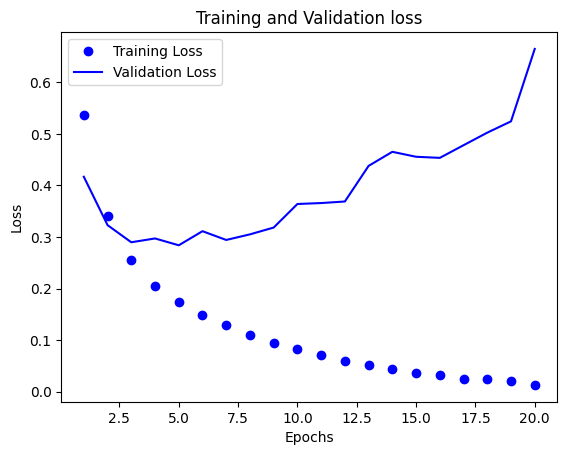

In [10]:

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

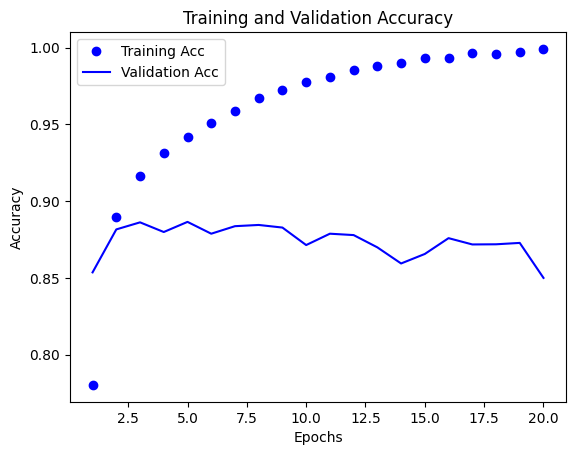

Done


In [11]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print ("Done")


In [12]:
# # create a model witl 8 units, compiule, train, plot
model_8 = tf.keras.models.Sequential()
model_8.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(10000,)))
model_8.add(tf.keras.layers.Dense(8, activation='relu'))
model_8.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_8.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [13]:

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = model_8.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - acc: 0.6763 - loss: 0.6252 - val_acc: 0.8346 - val_loss: 0.4616
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.8811 - loss: 0.4067 - val_acc: 0.8766 - val_loss: 0.3576
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9122 - loss: 0.2960 - val_acc: 0.8849 - val_loss: 0.3108
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9300 - loss: 0.2327 - val_acc: 0.8867 - val_loss: 0.2870
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9414 - loss: 0.1961 - val_acc: 0.8886 - val_loss: 0.2777
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.9468 - loss: 0.1659 - val_acc: 0.8877 - val_loss: 0.2770
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9580 - loss: 0.1410 - val_acc: 0.8878 - val_loss: 0.2802
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9664 - loss: 0.1215 - val_acc: 0.8841 - val_loss: 0.2914
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9672

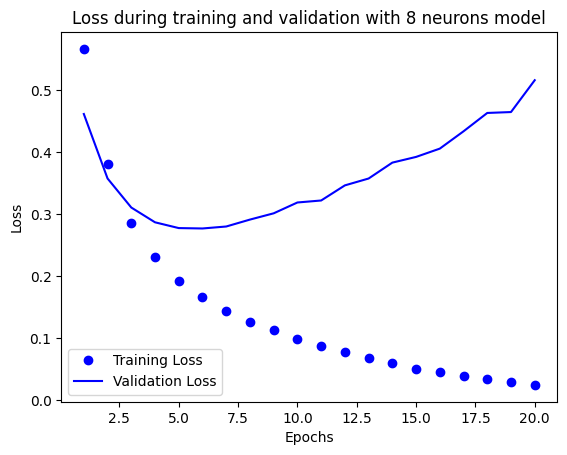

In [14]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Loss during training and validation with 8 neurons model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

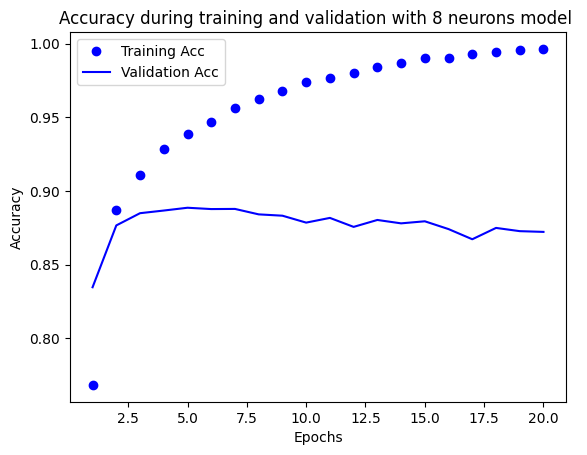

Done


In [15]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc,'b', label='Validation Acc')
plt.title('Accuracy during training and validation with 8 neurons model ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print ("Done")